# 프로젝트: AutoInt+ 모델 구현 및 시각화
이번에는 여러분이 직접 모델을 구현해 보고 스트림릿으로 시각화해 볼 차례입니다. Autoint 모델을 참고하여 Autoint+ 모델을 직접 구현해 보세요!

## 프로젝트 미션
여러분은 아래의 평가 기준을 만족시키는 결과물을 제출해야 합니다.  
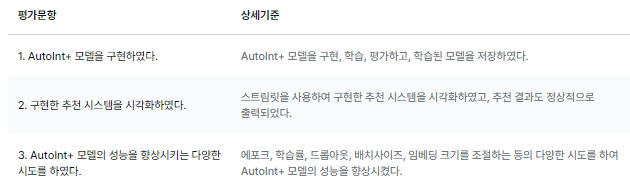

1. AutoInt 모델을 구현했던 과정을 참고하여 AutoInt+ 모델을 텐서플로우로 구현, 학습, 평가해 주세요.
학습된 모델을 제대로 저장하는 과정도 포함되어야 합니다.
2. 스트림릿을 사용하여 추천 시스템을 시각화하고, 추천 콘텐츠도 정상적으로 출력되도록 해 주세요.
AutoInt 모델 시각화를 위한 코드를 그대로 사용하셔도 되지만 시각화 페이지를 더 멋지게 꾸미거나 변경하여도 됩니다.
3. 다양한 시도를 하여 AutoInt+ 모델의 성능을 향상시켜 보세요.
에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기를 조절하거나 레이어를 더 쌓거나 활성화 함수를 변경시키는 등의 다양한 시도를 해보세요.

## AutoInt+ 모델
AutoInt+ 모델은 AutoInt에 2개의 레이어를 가진 피드포워드 뉴럴 네트워크(feedforward neural network)를 결합해 조인트(Joint) 훈련 방법을 진행한 모델로, 아래와 같은 구조를 가집니다.  
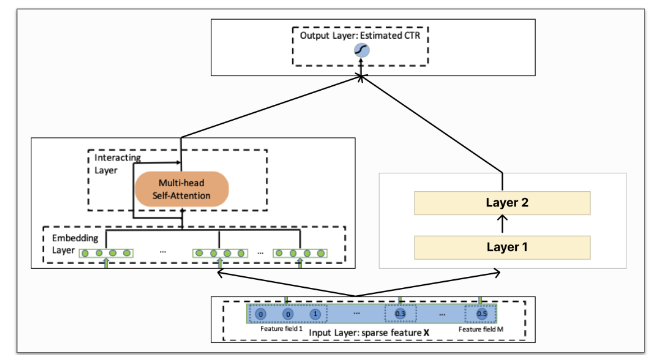

AutoInt+ 모델은 AutoInt 모델에서 사용했던 Layer(FeaturesEmbedding, MultiLayerPerceptron, MultiHeadSelfAttention)를 동일하게 사용합니다. AutoInt 모델 코드과 아래의 파이토치 코드를 참고하여 AutoInt+ 모델을 텐서플로우로 구현해 주세요.

코드에서는 AutoInt+ 모델을 AutoIntMLP라고 지칭하였습니다.

## 필요한 라이브러리 불러오기


In [1]:
import time
import random
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import math

## Layer 정의
AutoInt에 사용되는 Layer는 총 3가지입니다.

1. 임베딩 레이어
    - 임베딩 레이어는 raw input 데이터를 저차원 임베딩 공간에 매핑하는 과정을 의미합니다.
    - 예를 들어 성별이 남, 여가 있다면 이는 각각 0과 1로 매핑될 수 있고, 0에 해당되는 32차원 임베딩 공간, 1에 해당되는 임베딩 공간에 매핑하는 과정이죠.
2. 다층 퍼셉트론(MLP-Multilayer Perceptron, DNN 구조)
    - 딥러닝을 배우면 거의 가장 먼저 배울 수 있는 구조입니다.
    - 비선형 레이어를 쌓아올린 구조입니다. Dense mlayer를 쌓아올린 구조라고 보시면 됩니다.
3. 멀티 헤드 어텐션
    - 쿼리(query), 키(key), 값(value)에 따른 어텐션을 계산하는 구조입니다.
    - 본 모델에서는 셀프 어텐션 구조로 진행됩니다.

### 임베딩 레이어

In [2]:
class FeaturesEmbedding(Layer):  
    '''
    임베딩 레이어입니다. 
    - 만약 피처(feature) 3개가 각각 10개, 20개, 30개의 고유값을 가진다면 feature_dims는 [10, 20, 30] 형태를 띄게 됩니다.
    - 전체 임베딩을 해야 할 개수는 10+20+30 = 60이므로 '60 x 임베딩_차원_크기'의 행렬이 생성되게 됩니다.
    '''
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        # 임베딩을 빌드하고 초기화합니다.
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        # 들어온 입력의 임베딩을 가져니다.
        x = x + tf.constant(self.offsets, dtype=np.int64)
        return self.embedding(x)

### 다층 퍼셉트론

In [3]:
class MultiLayerPerceptron(Layer):  
    '''
    DNN 레이어입니다.
    - Tensorflow Keras에서는 Dense 레이어를 쌓아올린 구조입니다.
    - 필요에 따라 배치 정규화도 사용할 수 있습니다.
    '''
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]
        # Dense layer를 쌓아올립니다.
        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        # 활성화 함수를 세팅합니다.
        self.activation = tf.keras.layers.Activation(activation)
        # 필요하다면 배치정규화도 진행합니다.
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            # input data가 들어오면 layer를 돌면서 벡터 값을 가져오게 됩니다.
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            # 각 layer마다 나온 벡터 값에 활성화 함수와 dropout을 적용시켜 비선형성 구조와 과적합을 방지합니다.
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

멀티 헤드 어텐션
다음은 멀티헤드 셀프어텐션입니다.

수식으로 표현하면 아래와 같은 구조입니다. 트랜스포머와 동일한 구조입니다.  
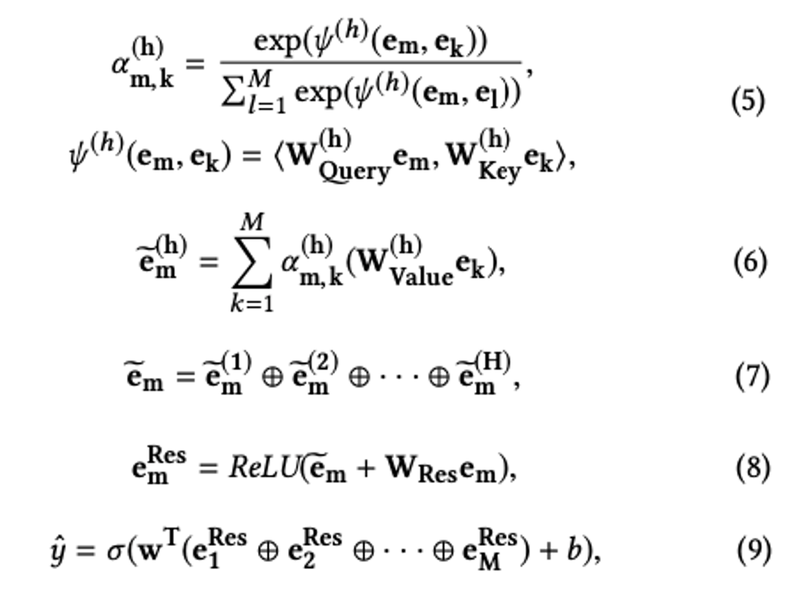

In [4]:
class MultiHeadSelfAttention(Layer):  
    '''
    멀티 헤드 셀프 어텐션 레이어입니다.
    - 위에 작성한 수식과 같이 동작됩니다.
    - 필요에 따라 잔차 연결(residual connection)도 진행합니다.
    '''
    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        # 쿼리에 해당하는 매트릭스입니다. 
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        # 키에 해당되는 매트릭스입니다.
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        # 값(value)에 해당되는 매트릭스입니다.
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        # 필요하다면 잔차 연결도 할 수 있습니다.
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        
        # 입력이 들어오면 쿼리, 키, 값(value)에 매칭되어 각각의 값을 가지고 옵니다.
        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))  
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        # 헤드 개수에 따라 데이터를 분리해줍니다.
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        # 쿼리와 키를 먼저 곱해줍니다. 위 이미지의 식 (5)와 같습니다.
        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)
        
        # 쿼리와 키에서 나온 어텐션 값을 값(value)에 곱해줍니다. 식 (6)과 같습니다.
        result = tf.matmul(self.normalized_att_scores, values)
        # 식 (7)과 같이 쪼개어진 멀테 헤드를 모아줍니다.
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)
        
        # 그 결과 값을 리턴합니다.

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num, 'use_res': self.use_res,'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config

In [5]:
# 파이토치 코드 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import normal_

class AutoIntMLP(nn.Module):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, dnn_hidden_units=(32, 32), dnn_activation='relu',
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001, device='cpu'):
        super(AutoIntMLP, self).__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size
        self.att_output_dim = self.num_fields * self.embedding_size
        self.embed_output_dim = len(field_dims) * embed_dim

        self.dnn_linear = nn.Linear(self.att_output_dim, 1, bias=False).to(device)
        self.dnn_hidden_units = dnn_hidden_units
        self.att_layer_num = att_layer_num
        self.dnn = MultiLayerPerceptron(self.embed_output_dim, dnn_hidden_units,
                           activation=dnn_activation, l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, use_bn=dnn_use_bn,
                           init_std=init_std, output_layer=True, device=device)
        self.int_layers = nn.ModuleList(
            [MultiHeadSelfAttention(self.embedding_size, att_head_num, att_res, device=device) for _ in range(att_layer_num)])

        self.to(device)

    def forward(self, X):
        embed_x = self.embedding(X)
        dnn_embed = embed_x
        att_input = embed_x
        
        for cnt, layer in enumerate(self.int_layers):
            att_input = layer(att_input)
            
        att_output = torch.flatten(att_input, start_dim=1)
        
        att_output = F.relu(self.dnn_linear(att_output))
        # autoint MLP
        dnn_output = self.dnn(dnn_embed.view(-1, self.embed_output_dim))
        
        y_pred = torch.sigmoid(att_output + dnn_output)

        return y_pred

### AutoInt+ 모델

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# 텐서플로우에서의 AutoInt+ MLP 레이어
class AutoIntMLP(Layer): 
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, dnn_hidden_units=(32, 32), dnn_activation='relu',
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoIntMLP, self).__init__()
        self.embedding = FeaturesEmbedding(field_dims, embedding_size, name="features_embedding")
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size

        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std), name="final_layer")
        
        self.dnn = MultiLayerPerceptron(input_dim=self.embedding_size * self.num_fields, hidden_units=dnn_hidden_units,
                                        activation=dnn_activation, l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, 
                                        use_bn=dnn_use_bn, init_std=init_std)
        
        self.int_layers = [MultiHeadSelfAttention(att_embedding_size=embedding_size, head_num=att_head_num, use_res=att_res, name=f"mhsa_{i}")
                           for i in range(att_layer_num)]

    def call(self, inputs):
        embed_x = self.embedding(inputs)
        dnn_embed = tf.reshape(embed_x, shape=(-1, self.embedding_size * self.num_fields))

        att_input = embed_x
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        att_output = self.final_layer(att_output)
        
        dnn_output = self.dnn(dnn_embed)
        y_pred = tf.nn.sigmoid(dnn_output + att_output)
        
        return y_pred

### 평가 지표

In [7]:
# 평가 함수는 아래의 링크에서 가져왔습니다.
# https://www.programcreek.com/python/?code=MaurizioFD%2FRecSys2019_DeepLearning_Evaluation%2FRecSys2019_DeepLearning_Evaluation-master%2FConferences%2FKDD%2FMCRec_our_interface%2FMCRecRecommenderWrapper.py
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

### 모델 테스트

In [8]:
def test_model(model, test_df):
    '''모델 테스트'''
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

## 데이터 불러오기 및 세팅
전처리하였던 데이터를 불러옵니다. 이 데이터를 모델에 바로 사용할 수 없는데요. 모델 input으로 넣어 학습하기 위해서는 다음과 같은 과정을 거쳐야 합니다.

1. 데이터 불러오기
2. 레이블 인코더(label encoder)를 통해 0부터 피처(feature)의 고유 개수까지 매핑
    - 예) 성별: 남(M), 여(F)를 0, 1로 변환
    - 예) 장르: 코메디, 드라마, 액션을 0, 1, 2로 변환
3. 학습(train) 데이터와 테스트(test) 데이터로 분리

하나씩 살펴봅시다.

In [9]:
# 1. 데이터 불러오기
# csv 데이터이므로 read_csv로 가져옵니다.
data_path = './aiffel/autoint/ml-1m'
movielens_rcmm = pd.read_csv(f"{data_path}/movielens_rcmm_v2.csv", dtype=str)
print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2000,12,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2000,12,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2000,12,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2000,12,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [10]:
# 2. 라벨 인코더(label encoder)
# sklearn의 LabelEncoder(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
# label은 제외한 각 컬럼을 돌면서 각각의 고윳값들을 0부터 n까지 매핑시킵니다.
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

In [11]:
movielens_rcmm.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,0,189,6,55,0,3,0,7,17,15,0,0,2,1588,1
1,0,3374,8,76,0,3,0,2,2,8,0,0,2,1588,0
2,0,3615,5,44,0,3,0,11,12,15,0,0,2,1588,0
3,0,2503,9,80,0,3,0,7,17,15,0,0,2,1588,1
4,0,1374,8,78,1,0,0,2,2,2,0,0,2,1588,1


In [12]:
movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

In [13]:
# 3. 학습 데이터와 테스트데이터로 분리, 0.2 정도로 분리
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)

In [14]:
# 필요 컬럼들과 레이블 정의
# 필드의 각 고유 개수를 정의하는 field_dims를 정의합니다. 이는  임베딩 때 활용됩니다. 
u_i_feature = ['user_id', 'movie_id']
meta_features = ['movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']
label = 'label'
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int32).values, axis=0) + 1
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439], dtype=int32)

## 훈련 환경 및 모델 세팅
이제 추천 모델 훈련을 진행하면 됩니다. 훈련에 앞서 환경을 정의해야겠죠?

1. 드롭아웃, 배치사이즈 등 모델 훈련, 모델 설정 등의 세팅
2. 모델 정의

두 가지를 정의합니다.

In [15]:
# 에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기 등 정의
epochs=100
learning_rate= 0.0001
dropout= 0.5
batch_size = 512
embed_dim= 16

# 텐서플로우에서의 AutoInt+ 모델
class AutoIntMLPModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True,
                 dnn_hidden_units=(32, 32), dnn_activation='relu', l2_reg_dnn=0, l2_reg_embedding=1e-5, 
                 dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoIntMLPModel, self).__init__()
        # AutoIntMLP 레이어를 초기화합니다.
        self.autoIntMLP_layer = AutoIntMLP(field_dims, embedding_size, att_layer_num=att_layer_num, att_head_num=att_head_num, 
                                           att_res=att_res, dnn_hidden_units=dnn_hidden_units, dnn_activation=dnn_activation, 
                                           l2_reg_dnn=l2_reg_dnn, l2_reg_embedding=l2_reg_embedding, dnn_use_bn=dnn_use_bn,
                                           dnn_dropout=dnn_dropout, init_std=init_std)

    def call(self, inputs, training=False):
        # 입력 데이터를 AutoIntMLP 레이어에 전달하여 결과를 반환합니다.
        return self.autoIntMLP_layer(inputs, training=training)

# 모델 정의
autoIntMLP_model = AutoIntMLPModel(field_dims, embed_dim, att_layer_num=3, att_head_num=2, att_res=True,
                                   dnn_hidden_units=(32, 32), dnn_activation='relu', l2_reg_dnn=0, 
                                   l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=dropout, 
                                   init_std=0.0001)

# 옵티마이저, 오차함수 정의
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

# 컴파일
autoIntMLP_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['binary_crossentropy'])

## 훈련 및 평가
이제 모델을 훈련하고 평가합시다!

훈련 후에는 NDCG와 Hitrate를 활용해 평가를 진행합니다.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상은 검증 손실
    patience=10,         # 10 에폭 동안 개선되지 않으면 학습 종료
    verbose=1,           # 로그 출력
    restore_best_weights=True  # 가장 좋은 모델의 가중치를 복원
)

history = autoIntMLP_model.fit(
    train_df[u_i_feature + meta_features],
    train_df[label],
    epochs=epochs,  # 에폭 수를 더 늘릴 수 있음
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping]  # 콜백 리스트에 추가
)

Epoch 1/100
1407/1407 [==============================] - 13s 7ms/step - loss: 0.6236 - binary_crossentropy: 0.6236 - val_loss: 0.5704 - val_binary_crossentropy: 0.5704
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5453 - binary_crossentropy: 0.5453 - val_loss: 0.5450 - val_binary_crossentropy: 0.5450
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5357 - binary_crossentropy: 0.5357 - val_loss: 0.5423 - val_binary_crossentropy: 0.5423
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5333 - binary_crossentropy: 0.5333 - val_loss: 0.5417 - val_binary_crossentropy: 0.5417
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5321 - binary_crossentropy: 0.5321 - val_loss: 0.5411 - val_binary_crossentropy: 0.5411
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5312 - binary_crossentropy: 0.5312 - val_loss: 0.5411 - val_binary_crossentropy:

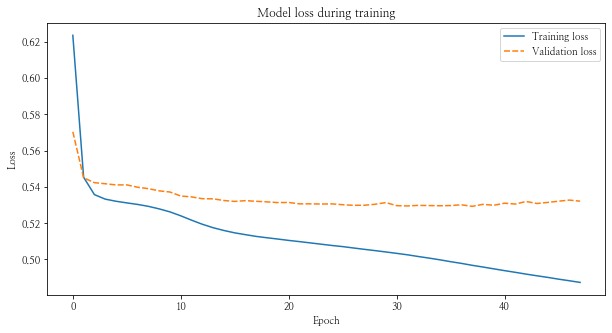

In [17]:
# 모델 학습 과정의 loss 값을 시각화하는 코드입니다.
import re 
import pandas as pd
#import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
plt.rc('font', family='NanumMyeongjo')

history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10, 5))
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right');
plt.show()

In [18]:
autoIntMLP_model.summary()

Model: "auto_int_mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
auto_int_mlp (AutoIntMLP)    multiple                  232977    
Total params: 232,977
Trainable params: 232,977
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}
# top10개
top = 10
# 테스트 값을 가지고 옵니다. 
mymodel_user_pred_info = test_model(autoIntMLP_model, test_df)
# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져옵니다. 
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져옵니다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

100%|██████████| 6035/6035 [00:00<00:00, 78403.43it/s]


In [20]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교합니다.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|██████████| 5994/5994 [00:00<00:00, 25202.83it/s]


In [21]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.66825
 mymodel hitrate :  0.63629


In [22]:
np.save('./aiffel/autoint/field_dims_mlp.npy', field_dims)

In [23]:
autoIntMLP_model.save_weights('./aiffel/autoint/model/autoIntMLP_model_weights.weights.h5')

In [24]:
import joblib 

joblib.dump(label_encoders, './aiffel/autoint/autoIntMLP_label_encoders.pkl')

['./aiffel/autoint/autoIntMLP_label_encoders.pkl']

In [25]:
autoIntMLP_model.save('./aiffel/autoint/model/autoIntMLP_model', save_format = 'tf')

INFO:tensorflow:Assets written to: ./aiffel/autoint/model/autoIntMLP_model/assets


INFO:tensorflow:Assets written to: ./aiffel/autoint/model/autoIntMLP_model/assets


In [26]:
autoIntMLP_model.summary()

Model: "auto_int_mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
auto_int_mlp (AutoIntMLP)    multiple                  232977    
Total params: 232,977
Trainable params: 232,977
Non-trainable params: 0
_________________________________________________________________


In [27]:
autoIntMLP_model.load_weights('./aiffel/autoint/model/autoIntMLP_model.weights.h5')

# streamlit으로 구현

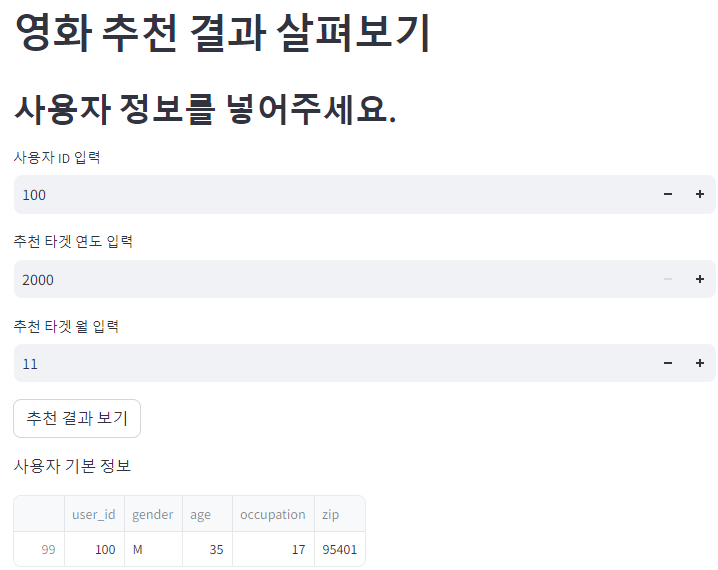  
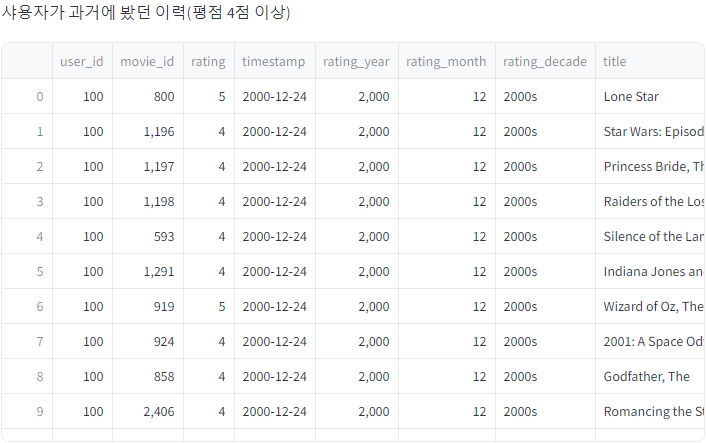  
예시 이미지와 동일하게 구현된다.

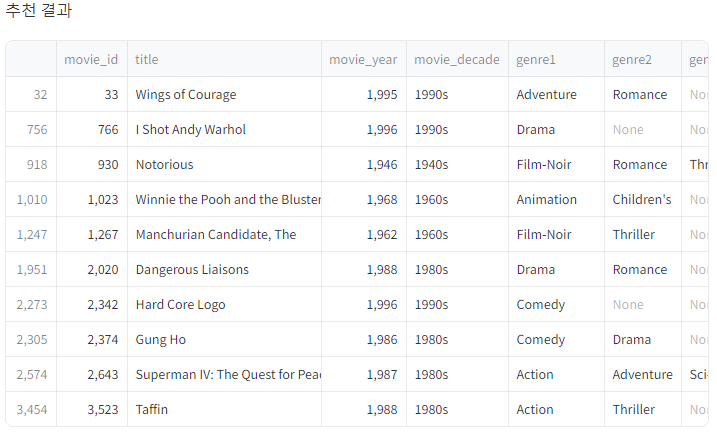  
추천 내역

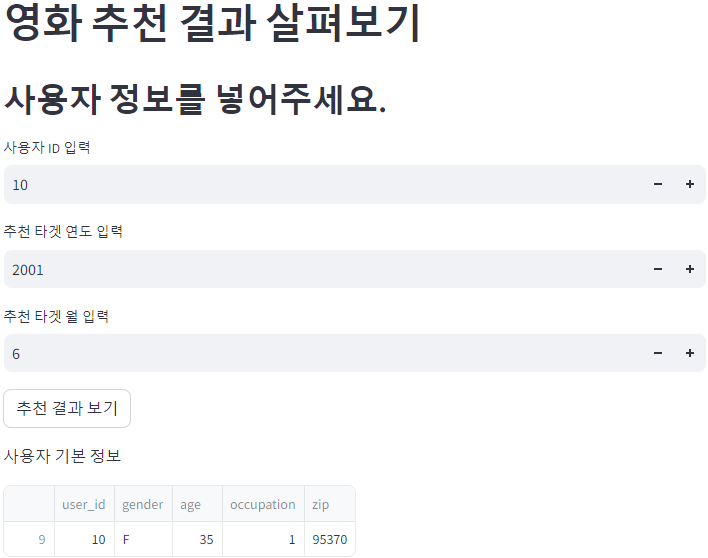
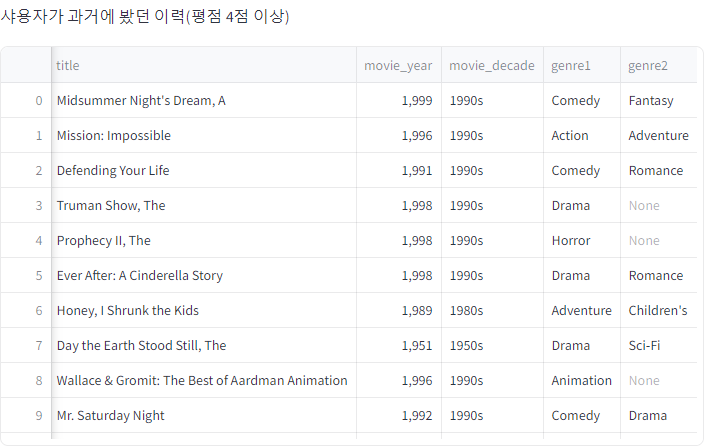
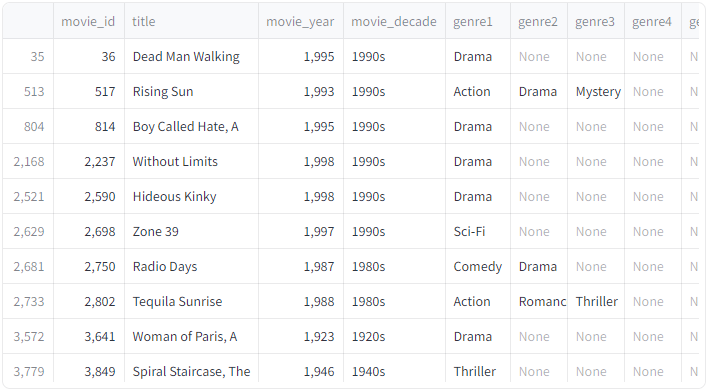

잘 동작하는 것 같다.

# 회고
마지막 strealit 구현 단계에서 해결이 안돼서 너무너무너무너무너무 스트레스를 받았습니다.  
로컬에서 가중치 파일을 저장할 때는 `.weights.weights.h5` 형태로 저장해야 했는데요, 클라우드에서 실행할 때는 `.weights.h5` 형태로 저장해야 실행됐습니다.  
하나 차이가 결과를 좌지우지하네요 정말...  
아무튼 이거 때문에 며칠을 붙들고 있었는데 드디어 끝내서 후련합니다...